In [114]:
# Some basic setup:
import torch, torchvision

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
import os, json, cv2, random
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm 
from sklearn.metrics import mean_squared_error

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import Keypoints
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [13]:
movie_name = 'MVI_7934.mov'

In [2]:
def load_dataset(metadata_path: str='Detectron-4.json', data_path: str='./datasets/Detectron/'):
    
    with open(metadata_path, 'r') as f:
        data = json.load(f)
        
    for annot in data['annotations']:
        if 'keypoints' not in annot:
            annot['keypoints'] = [0] * 21
            
    skeleton = dict(zip(list(range(len(data['categories'][0]['keypoints']))), data['categories'][0]['keypoints']))
    print(skeleton)
    conncted = []
    for start, end in data['categories'][0]['skeleton']:
        conncted.append([skeleton[start - 1], skeleton[end - 1], (0, 255, 0)])
    
    if 'Swimming' not in MetadataCatalog.list():    
        register_coco_instances("Swimming", {}, metadata_path, data_path)

        MetadataCatalog.get("Swimming").set(keypoint_names=data['categories'][0]['keypoints'])
        MetadataCatalog.get("Swimming").set(keypoint_flip_map=[['RSholder', 'LShoulder'], ['RWrist', 'LWrist'], ['RElbow', 'LElbow']])
        MetadataCatalog.get("Swimming").set(keypoint_connection_rules=conncted)
    
    return data

In [5]:
def get_model(trained: bool=True, score_tresh: int=0.75):
    
    cfg = get_cfg()
    
    if trained:
        cfg.merge_from_file(
        model_zoo.get_config_file(f"COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
        )
        cfg.DATALOADER.NUM_WORKERS = 2
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 7
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_tresh   # set the testing threshold for this model
        cfg.DATASETS.TEST = ("Swimming", )
        cfg.TEST.DETECTIONS_PER_IMAGE = 1
        predictor = DefaultPredictor(cfg)
        
    else:
        cfg.merge_from_file(
        model_zoo.get_config_file(f"COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
        )
        cfg.MODEL.WEIGHTS = f"detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"  # initialize 
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_tresh   # set the testing threshold for this model
        cfg.TEST.DETECTIONS_PER_IMAGE = 1
        predictor = DefaultPredictor(cfg)

    return predictor, cfg

In [7]:
def load_video(path: str) -> np.ndarray:

    frames = []
    vidcap = cv2.VideoCapture(path)
    success, image = vidcap.read()
    frames.append(image)
    while success:
        success, image = vidcap.read()
        frames.append(image)
    
    return np.array(frames[:-1])

In [208]:
def get_model_predictions(model, frames):
    
    key_to_conf = {'Neck': 0.02,
                   'RSholder': 0.02,
                   'RElbow': 0.07,
                   'RWrist': 0.07,
                   'LShoulder': 0.02,
                   'LElbow': 0.07,
                   'LWrist': 0.07}
    
    keypoints_names = model.metadata.keypoint_names
    idx2name = {v: k for k, v in name2idx.items()}
    
    points_loc = {}
    
    for frame in tqdm(frames):
        outputs = model(frame)
        keypoints = outputs['instances'].get_fields()['pred_keypoints'].cpu().numpy()
        if keypoints.shape[0] == 0:
            keypoints = [[0, 0, 0]] * (len(idx2name) + 4)
        else:
            keypoints = keypoints[0]
            
        for key, name in idx2name.items():
            x, y, conf = keypoints[key]
            if idx2name[key] not in points_loc:
                points_loc[name] = [[], []]
        
            if conf > key_to_conf[name]:
                points_loc[name][0].append(x)
                points_loc[name][1].append(y)
            
            else:
                points_loc[name][0].append(0)
                points_loc[name][1].append(0)
    
    return points_loc

In [209]:
def get_movie_labels(dataset, movie_path):
    movie_name = movie_path.split('/')[-1].split('.')[0]
    name_len = len(movie_name)
    labels = {}
    for i, image_metadata in enumerate(dataset['images']):
        if image_metadata['file_name'].startswith(movie_name):
            frame_num = int(image_metadata['file_name'][name_len:].split('.')[0]) -1
            labels[frame_num] = dataset['annotations'][i]['keypoints']
            
    keypoint_names = ['Neck', 'RSholder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
    
    keypoint_points = dict(zip(keypoint_names, [[[], []] for x in range(len(keypoint_names))]))
    for num, frame in labels.items():
        points = [frame[i:i+3] for i in range(0, len(frame), 3)]
        for (x, y, _), (name) in zip(points, keypoint_names):
            keypoint_points[name][0].append(x)
            keypoint_points[name][1].append(y)
    return keypoint_points

In [212]:
def get_line_graphs(pretrained_points, trained_points, gt_points):
    
    for (keypoint_name, (pre_x, pre_y)), (_, (train_x, train_y)), (_, (gt_x, gt_y)) in zip(pretrained_points.items(),
                                 trained_points.items(),
                                 gt_points.items()):
        plt.plot(range(len(pre_x)), pre_x, '-', c='red', label='pretrained')
        plt.plot(range(len(train_x)), train_x, '-', c='blue', label='trained')
        plt.plot(range(len(gt_x)), gt_x, 'o', c='green',label='ground truth') # mec='red', mfc='white', 
        
        plt.title(f'{keypoint_name} X')
        plt.xlabel('Frame')
        plt.ylabel('X Location')
        plt.legend(loc='best')
        plt.show()
                            
        plt.plot(range(len(pre_y)), pre_y, '-', c='red', label='pretrained')
        plt.plot(range(len(train_y)), train_y, '-', c='blue', label='trained')
        plt.plot(range(len(gt_y)), gt_y, 'o', c='green',label='ground truth') # mec='red', mfc='white', 
        
        plt.title(f'{keypoint_name} Y')
        plt.xlabel('Frame')
        plt.ylabel('Y Location')
        plt.legend(loc='best')
        plt.show()

In [ ]:
dataset = load_dataset()

In [ ]:
swimming_metadata = MetadataCatalog.get("Swimming")
dataset_dicts = DatasetCatalog.get("Swimming")

In [ ]:
trained_model, trained_cfg = get_model(trained=True)
pretrained_model, pretrained_cfg = get_model(trained=False)

In [213]:
frames = load_video(movie_name)
labels = get_movie_labels(dataset, movie_name)

MVI_7934


In [214]:
trained_points = get_model_predictions(trained_model, frames)
pretrained_points = get_model_predictions(pretrained_model, frames)

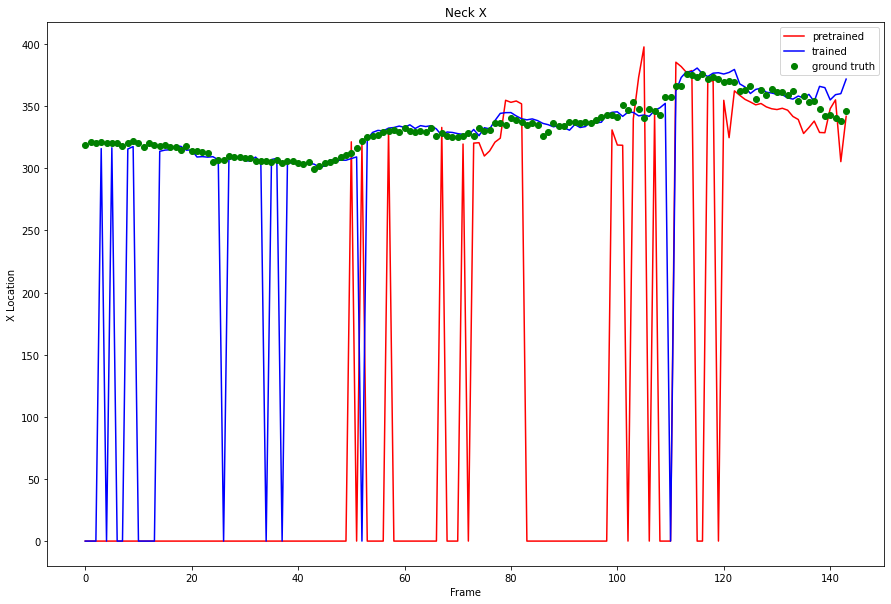

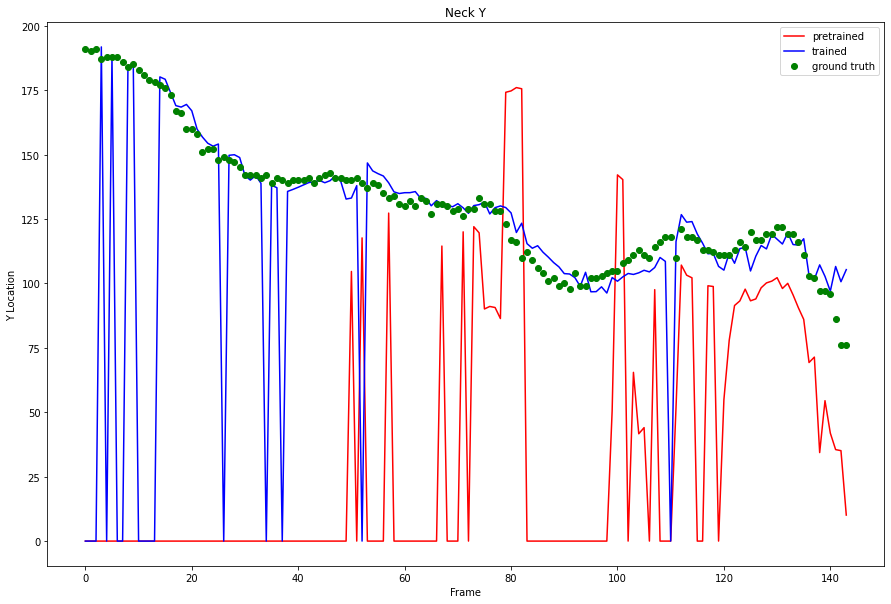

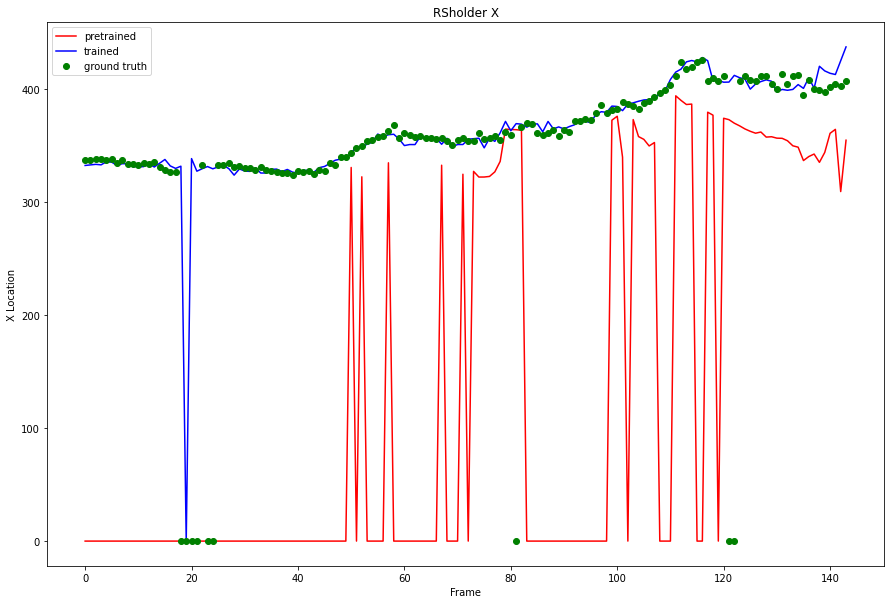

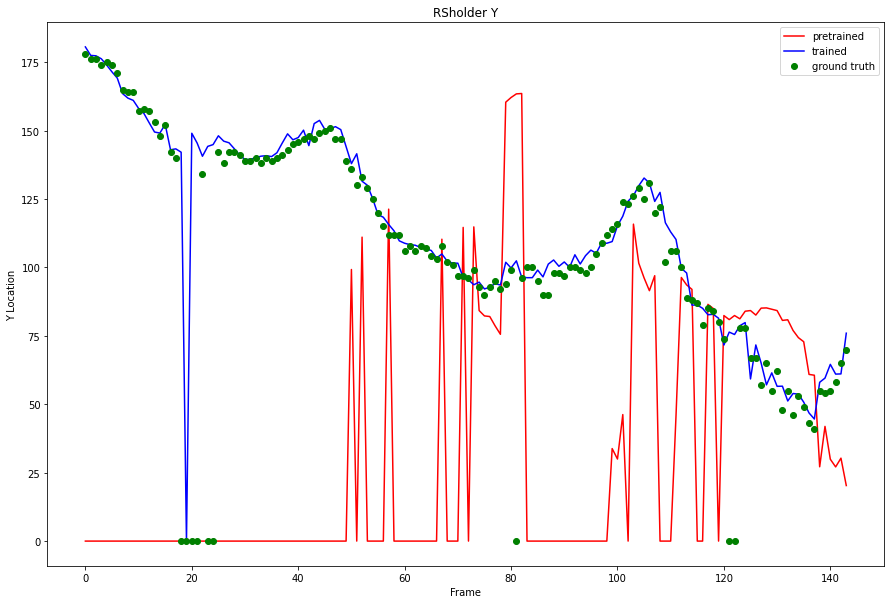

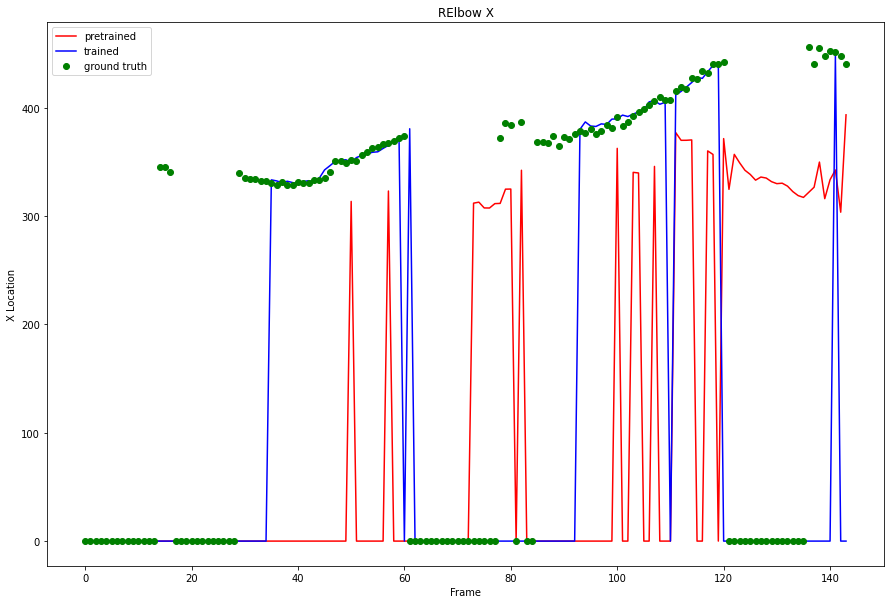

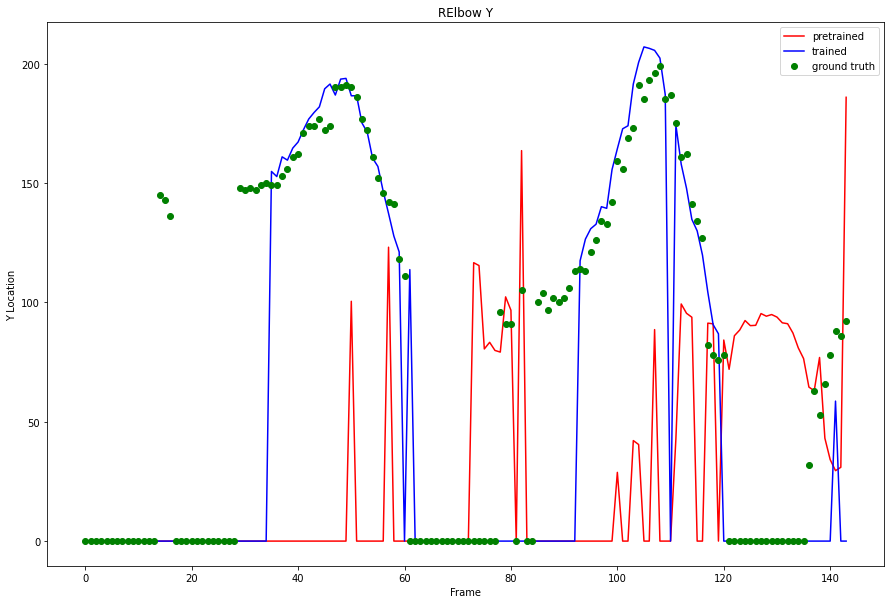

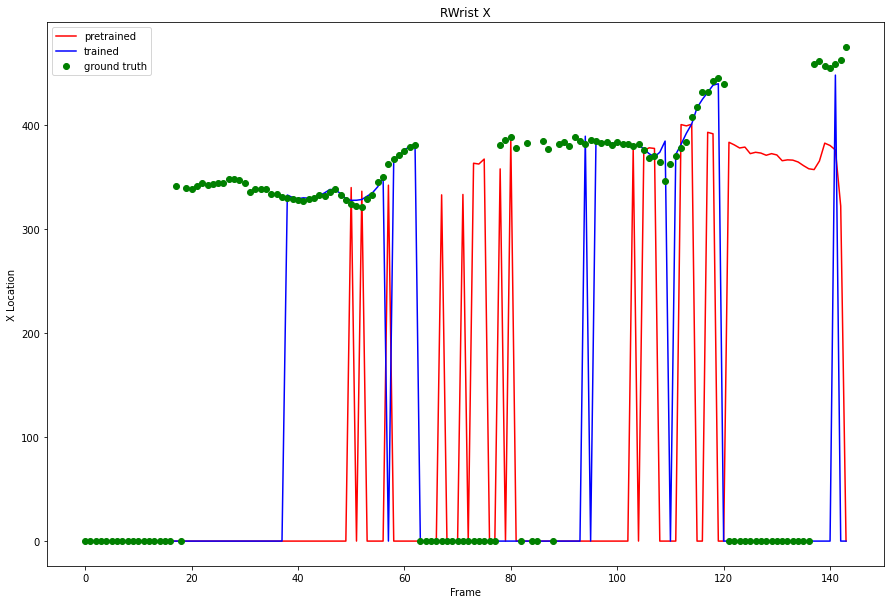

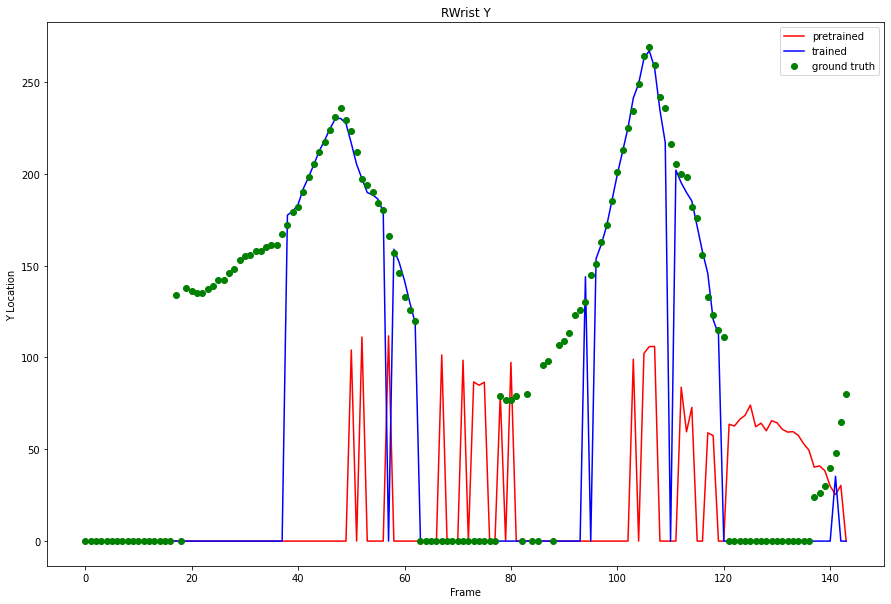

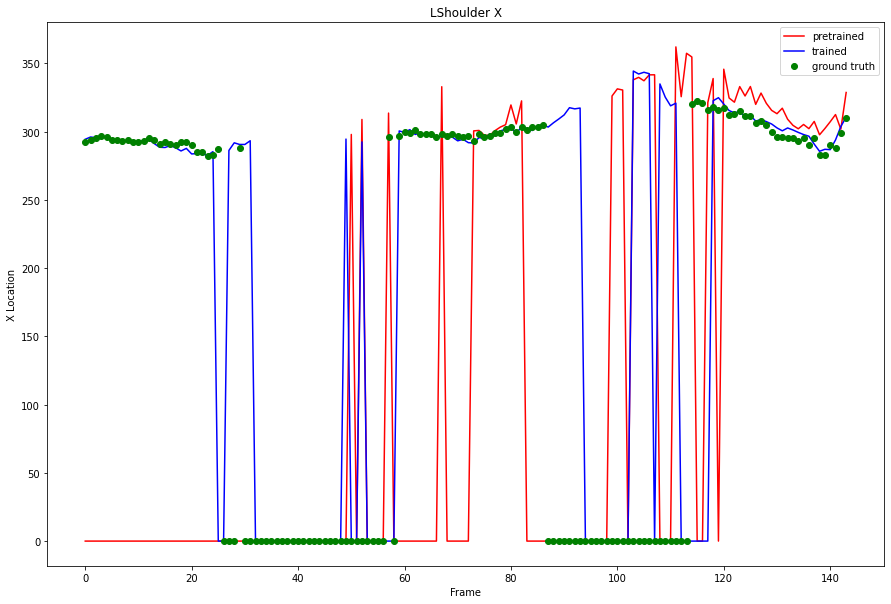

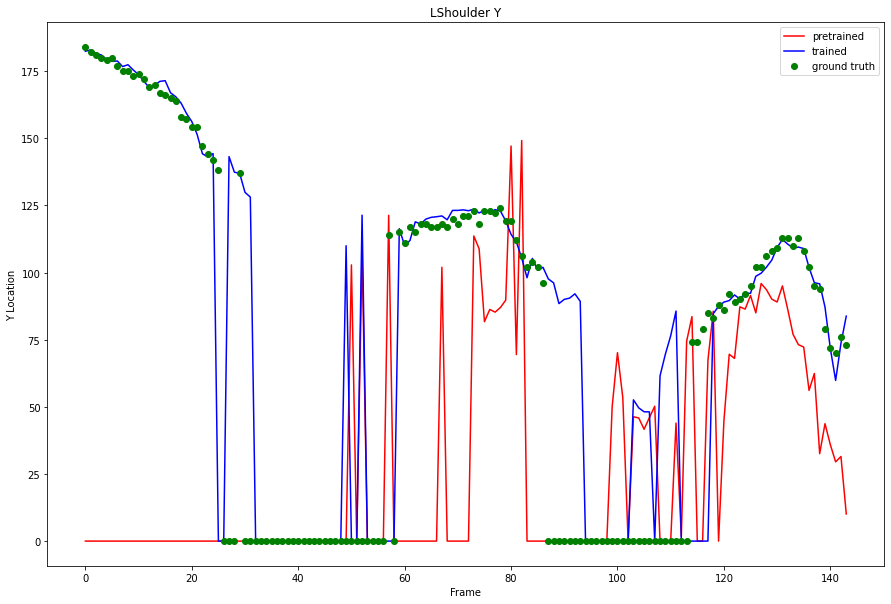

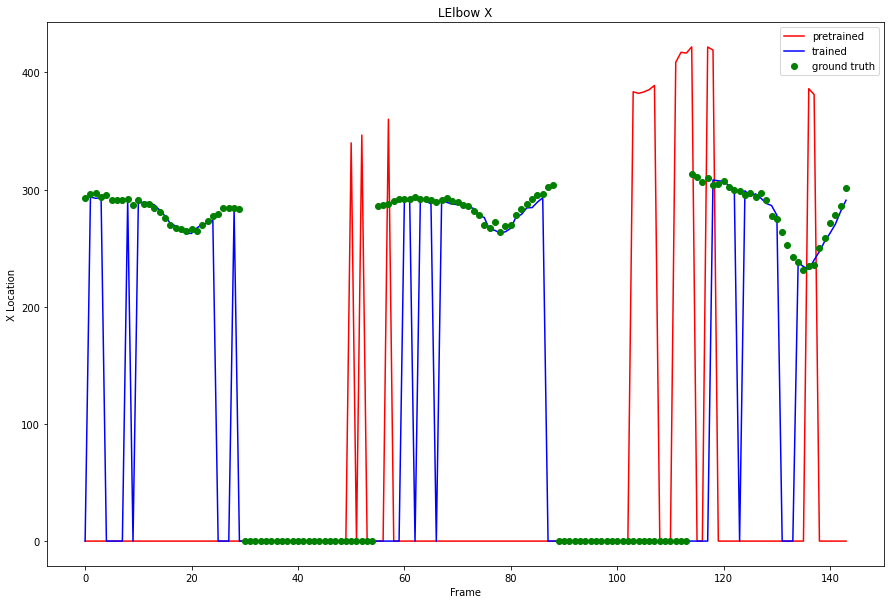

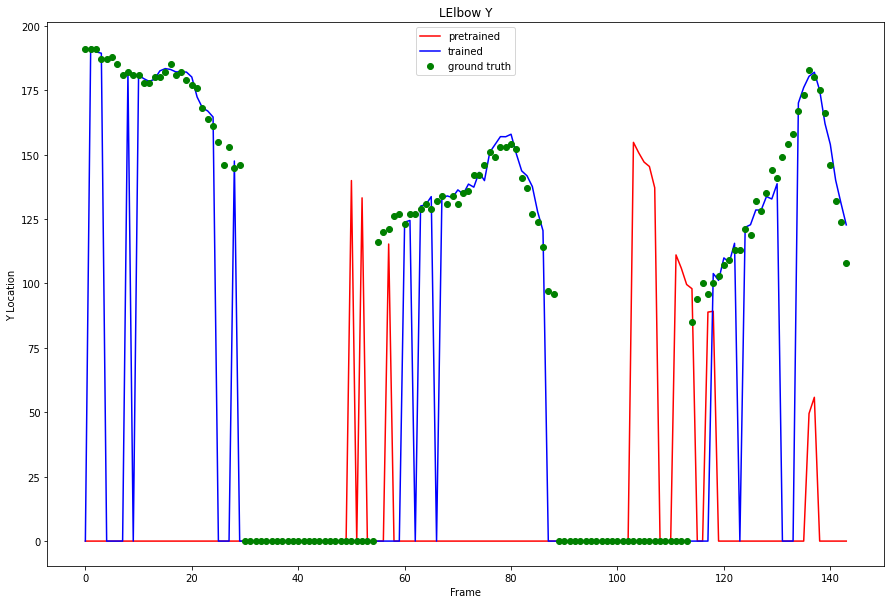

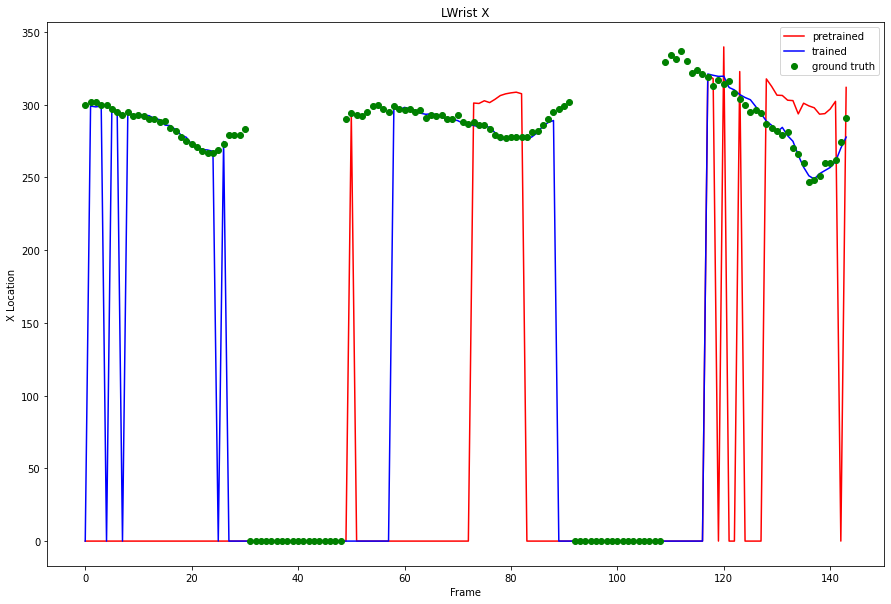

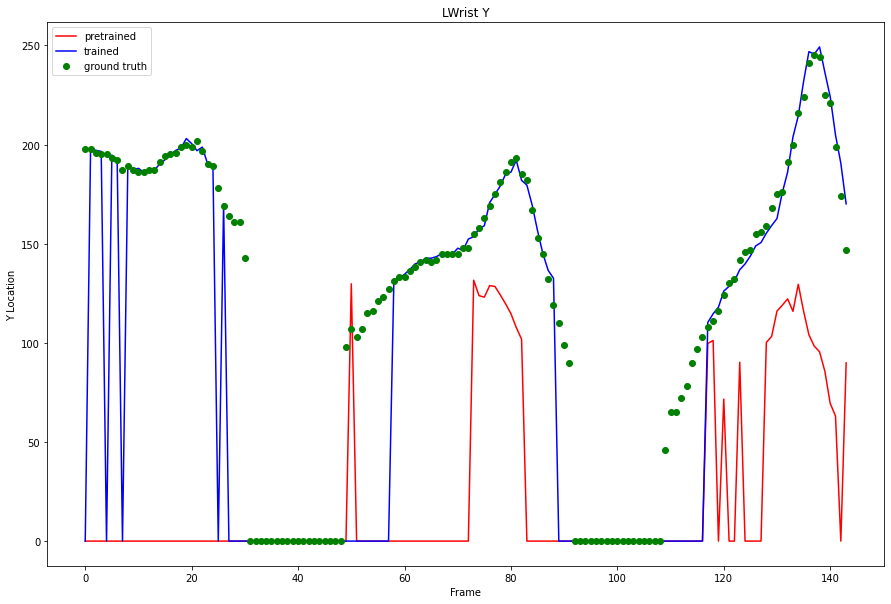

In [215]:
get_line_graphs(pretrained_points, trained_points, labels)

In [216]:
def rmse(pretrained_points, trained_points, gt_points, type_):
    
    for (keypoint_name, (pre_x, pre_y)), (_, (train_x, train_y)), (_, (gt_x, gt_y)) in zip(pretrained_points.items(),
                                 trained_points.items(),
                                 gt_points.items()):
        pre_x, pre_y = np.array(pre_x), np.array(pre_y)
        train_x, train_y = np.array(train_x), np.array(train_y)
        gt_x, gt_y = np.array(gt_x), np.array(gt_y)
        
        if type_ == 'mutual':
            x_mask = np.logical_and(pre_x != 0, train_x != 0)
            y_mask = np.logical_and(pre_y != 0, train_y != 0)
        elif type_ == 'labeled':
            x_mask = gt_x != 0
            y_mask = gt_y != 0
        
        pre_x, pre_y = pre_x[x_mask], pre_y[y_mask]
        train_x, train_y = train_x[x_mask], train_y[y_mask]
        gt_x, gt_y = gt_x[x_mask], gt_y[y_mask]
        
        pre_x_rmse = mean_squared_error(gt_x, pre_x, squared=False)
        pre_y_rmse = mean_squared_error(gt_y, pre_y, squared=False)
        train_x_rmse = mean_squared_error(gt_x, train_x, squared=False)
        train_y_rmse = mean_squared_error(gt_y, train_y, squared=False)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.bar([0], [pre_x_rmse], label='pretrained')
        ax1.bar([1], [train_x_rmse], label='trained')
        ax1.set_title(f'{keypoint_name} X')
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(['pretrained', 'trained'])
        ax1.set_ylabel('RMSE')
        ax1.legend()
        
        ax2.bar([0], [pre_y_rmse], label='pretrained')
        ax2.bar([1], [train_y_rmse], label='trained')
        ax2.set_title(f'{keypoint_name} Y')
        ax2.set_xticks([0, 1])
        ax2.set_xticklabels(['pretrained', 'trained'])
        ax2.set_ylabel('RMSE')
        ax2.legend()
        
        plt.show()

In [228]:
def get_cm_params(preds, gt):
    tp = preds[np.logical_and(gt != 0, preds != 0)].shape[0]
    fp = preds[np.logical_and(gt == 0, preds != 0)].shape[0]
    p = preds[preds != 0].shape[0]

    tn = preds[np.logical_and(gt == 0, preds == 0)].shape[0]
    fn = preds[np.logical_and(gt != 0, preds == 0)].shape[0]
    n = preds[preds == 0].shape[0]
    
    return (tp, fp, p), (tn, fn, n)

In [239]:
def print_model_statistics(pretrained_points, trained_points, gt_points):
    for (keypoint_name, (pre_x, pre_y)), (_, (train_x, train_y)), (_, (gt_x, gt_y)) in zip(pretrained_points.items(),
                                 trained_points.items(),
                                 gt_points.items()):
        
        pre = np.array(pre_x)
        train = np.array(train_x)
        gt = np.array(gt_x)
        
        (pre_tp, pre_fp, pre_p), (pre_tn, pre_fn, pre_n) = get_cm_params(pre, gt)
        
        (train_tp, train_fp, train_p), (train_tn, train_fn, train_n) = get_cm_params(train, gt)
        
        print(f'{keypoint_name} X:')
        print(f'\tPretrained model- Recall: {round(pre_tp / (pre_tp + pre_fn), 3) * 100}% Precision: {round(pre_tp / (pre_tp + pre_fp), 3) * 100}%')
        print(f'\tTrained model- Recall: {round(train_tp / (train_tp + train_fn), 3) * 100}% Precision: {round(train_tp / (train_tp + train_fp), 3) * 100}%')
        print()

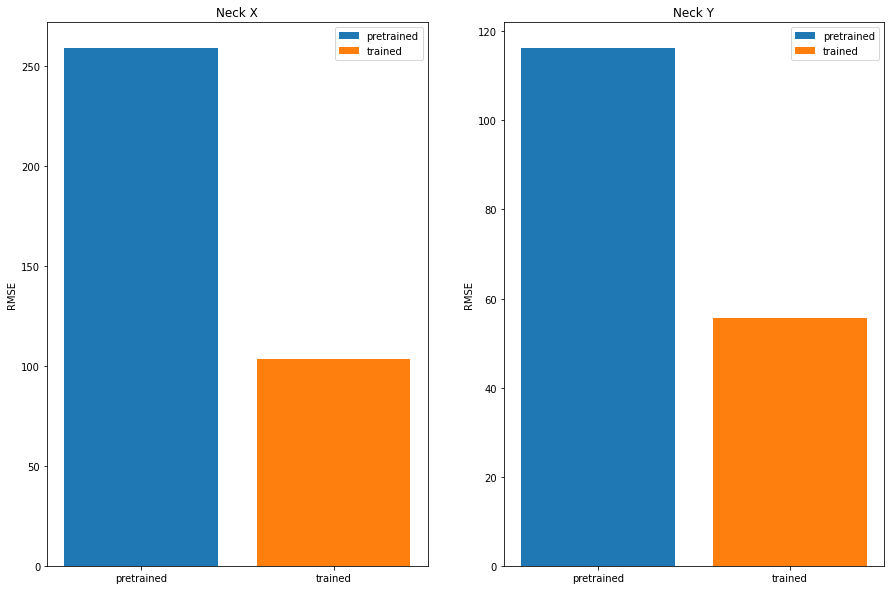

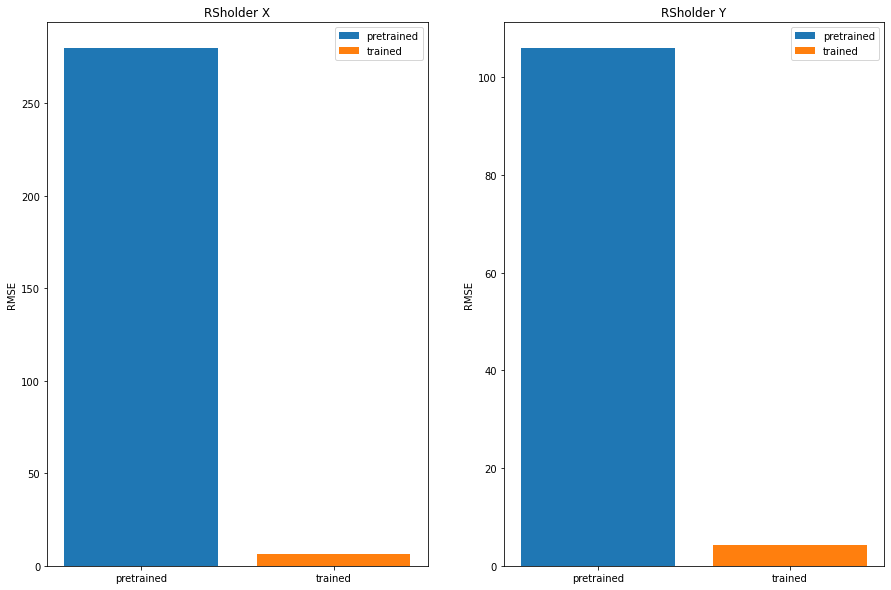

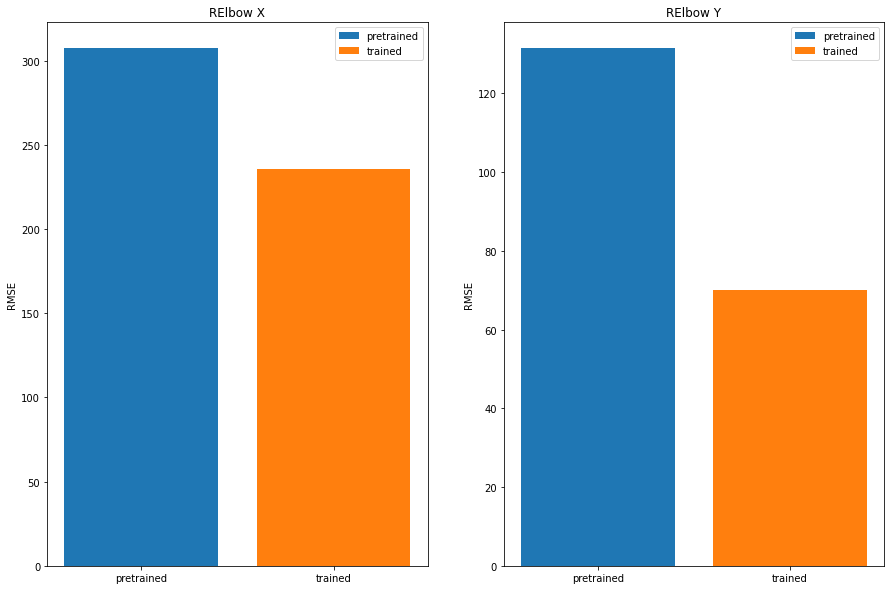

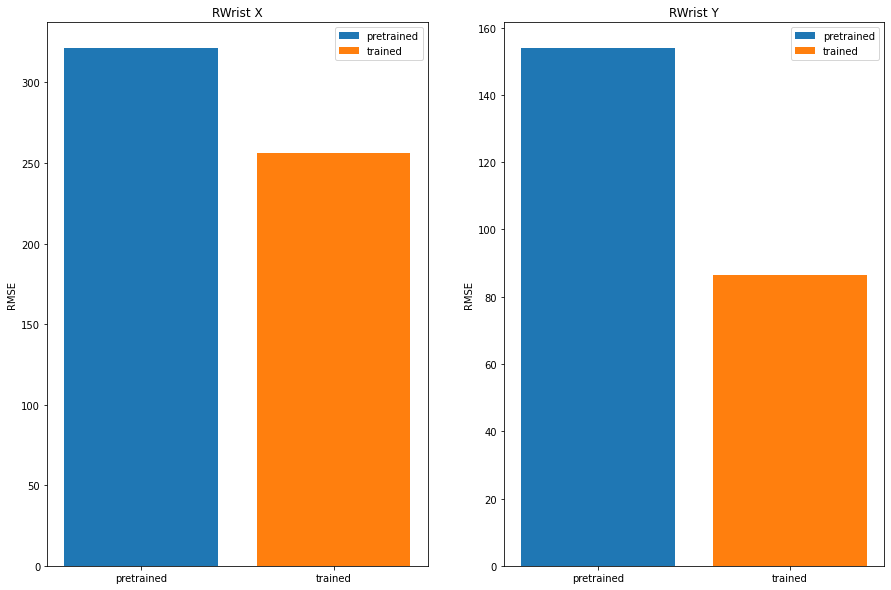

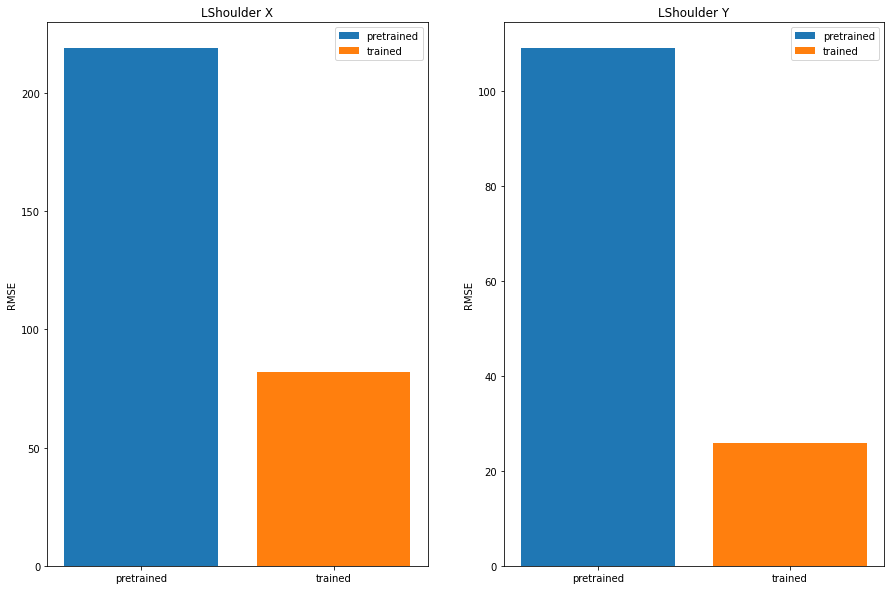

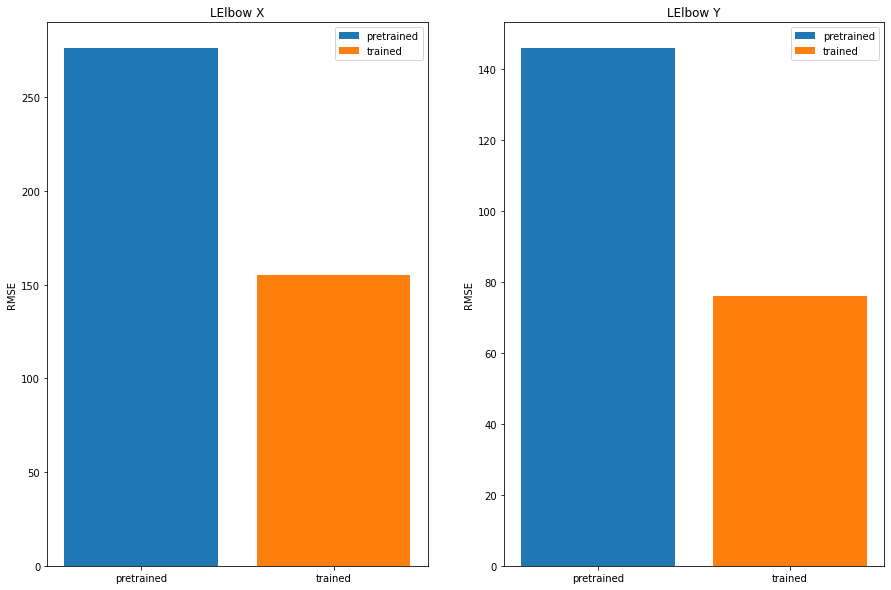

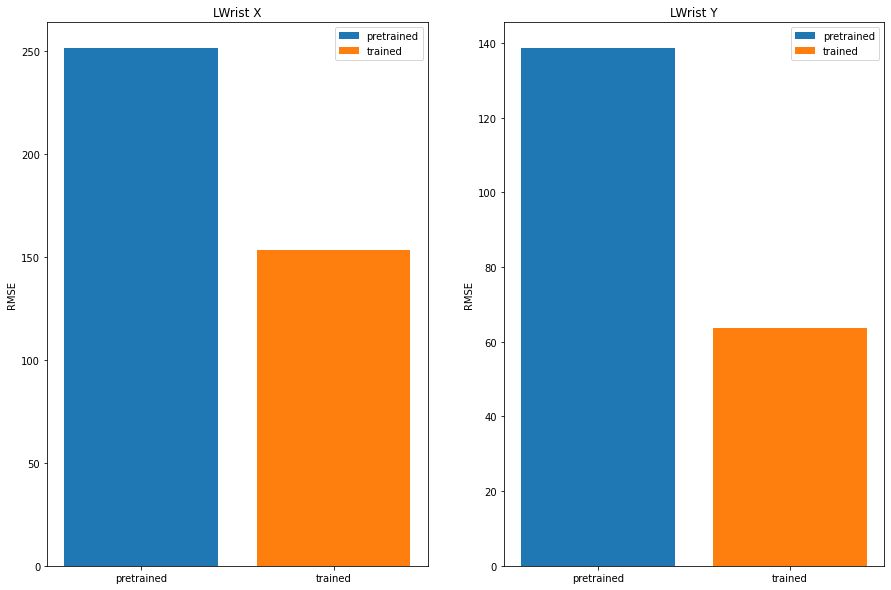

In [217]:
rmse(pretrained_points, trained_points, labels, type_='labeled')

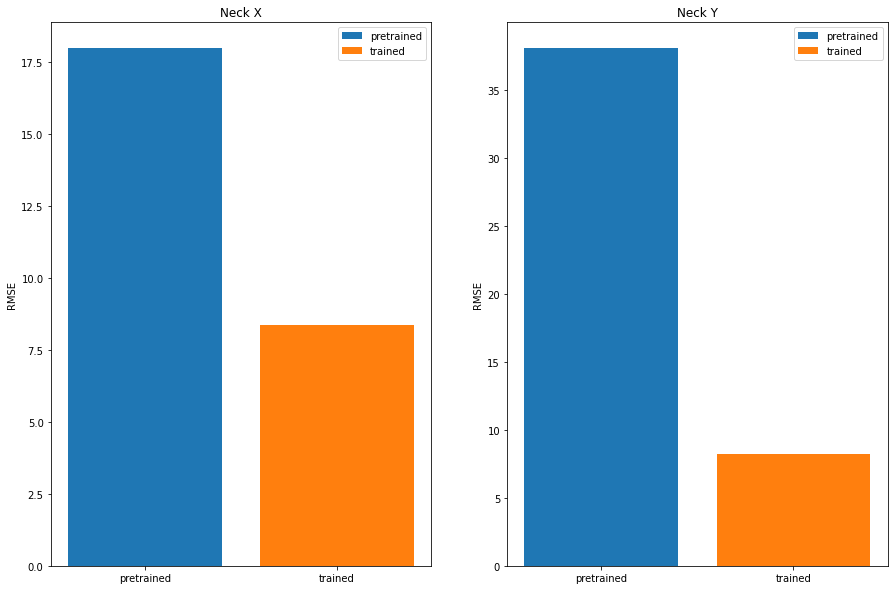

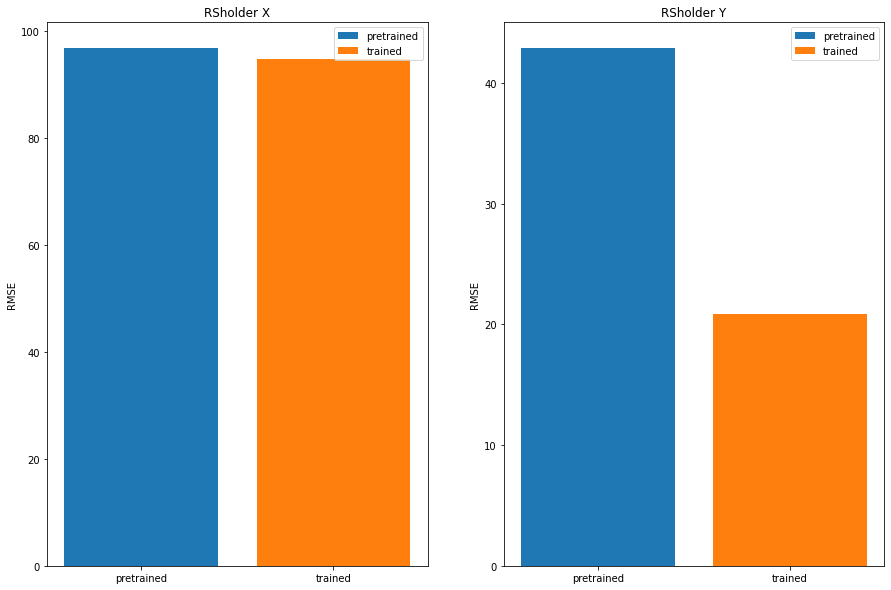

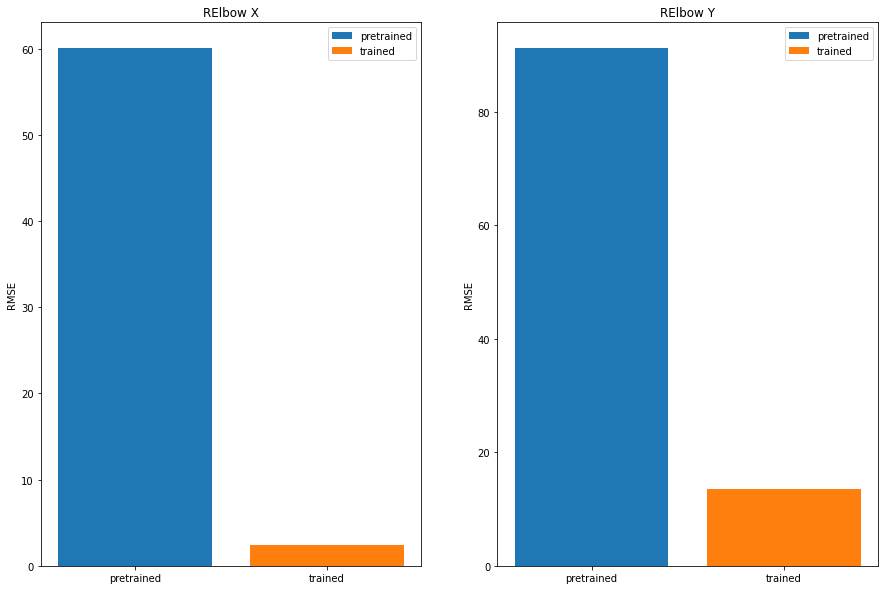

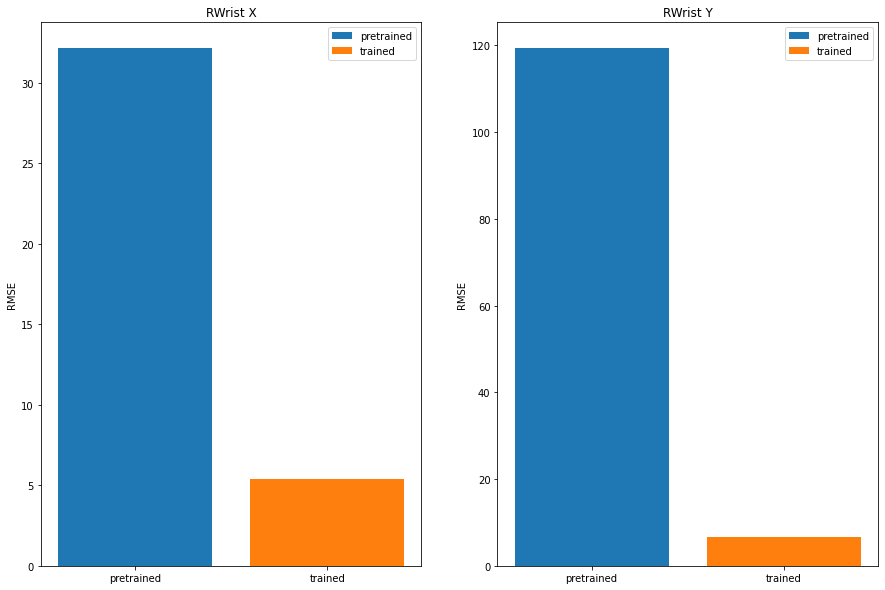

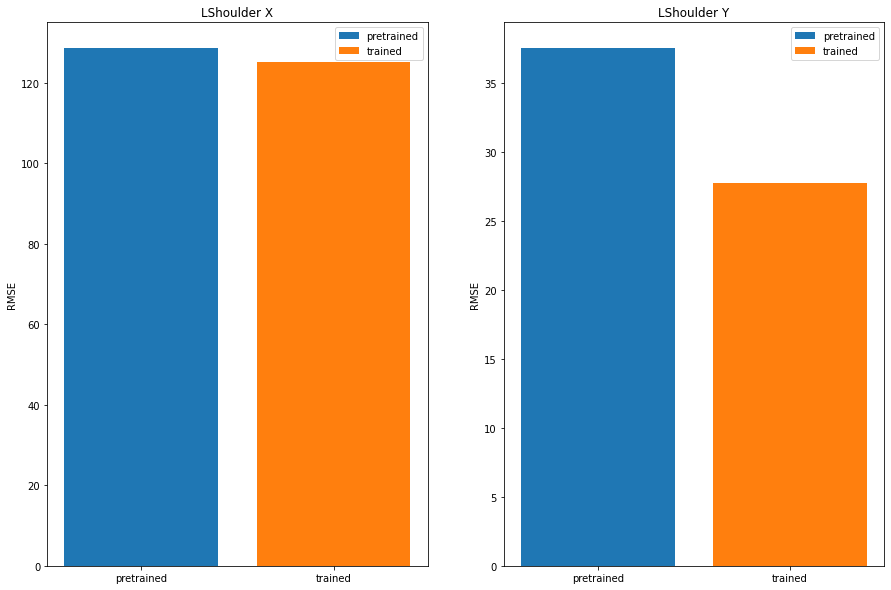

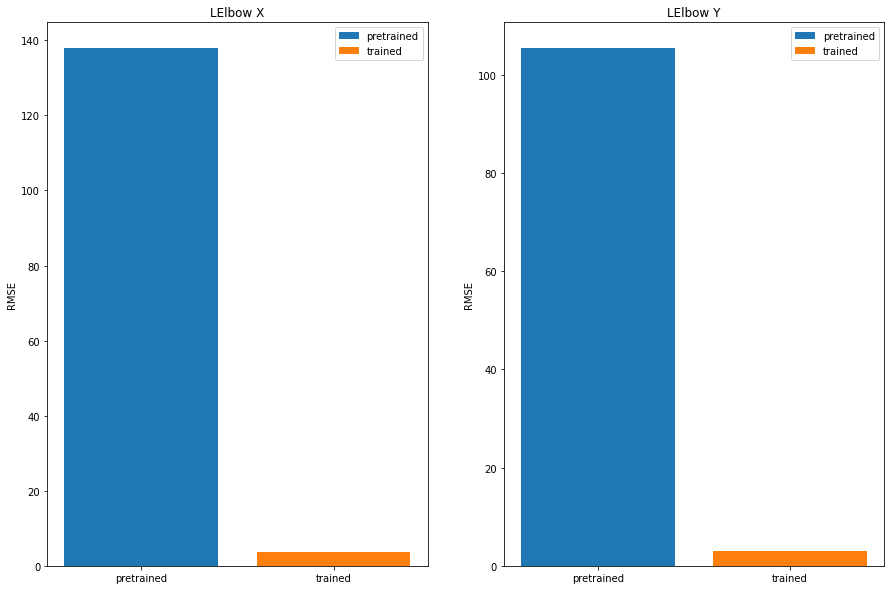

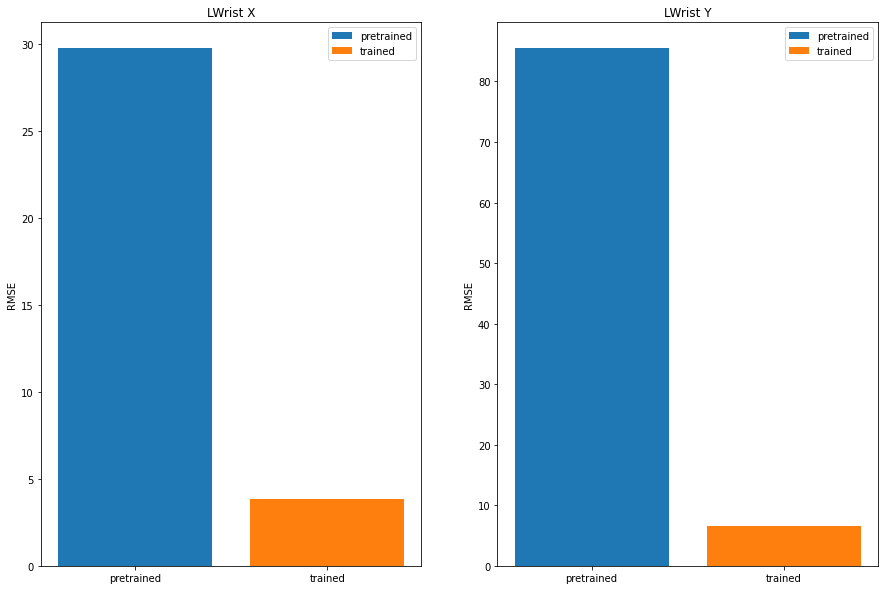

In [218]:
rmse(pretrained_points, trained_points, labels, type_='mutual')

In [241]:
print_model_statistics(pretrained_points, trained_points, labels)

Neck X:
	Pretrained model- Recall: 36.1% Precision: 100.0%
	Trained model- Recall: 89.60000000000001% Precision: 100.0%

RSholder X:
	Pretrained model- Recall: 37.0% Precision: 94.3%
	Trained model- Recall: 100.0% Precision: 94.39999999999999%

RElbow X:
	Pretrained model- Recall: 30.099999999999998% Precision: 55.60000000000001%
	Trained model- Recall: 62.7% Precision: 98.1%

RWrist X:
	Pretrained model- Recall: 22.0% Precision: 48.8%
	Trained model- Recall: 53.800000000000004% Precision: 100.0%

LShoulder X:
	Pretrained model- Recall: 45.300000000000004% Precision: 75.0%
	Trained model- Recall: 93.0% Precision: 79.2%

LElbow X:
	Pretrained model- Recall: 6.4% Precision: 37.5%
	Trained model- Recall: 71.3% Precision: 100.0%

LWrist X:
	Pretrained model- Recall: 27.500000000000004% Precision: 100.0%
	Trained model- Recall: 74.3% Precision: 100.0%

